# First bar & pivot points & day High Low - Analytics

### Import Library

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns
import math

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.constrained_layout.use'] = True
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
def bar10h(tick):
    tick=tick[(tick.index.hour == 10) & (tick.index.minute == 0)]
    if len(tick):
        return tick[0]

data['Close_10h'] = data['Close']
day_data = data.resample('D').agg({
        'Open': 'first',
        'Close': 'last',
        'High': 'max',
        'Low': 'min',
        'Close_10h': bar10h
    })
day_data.dropna(subset=['Close'], inplace=True)

In [5]:
day_data['Pivot'] = day_data.apply(lambda row: (row['High'] + row['Low'] + row['Close']) / 3, axis=1)
day_data['Pivot'] = day_data['Pivot'].shift(1)
day_data['open_vs_pivot'] = day_data.apply(lambda r: 1000 * (r['Open'] - r['Pivot']) / r['Open'], axis=1)
day_data['close10h_vs_pivot'] = day_data.apply(lambda r: 1000 * (r['Close_10h'] - r['Pivot']) / r['Close_10h'], axis=1)
day_data['high_vs_pivot'] = 1000 * (day_data['High'] - day_data['High'].shift(1)) / day_data['Pivot']
day_data['low_vs_pivot'] = 1000 * (day_data['Low'] - day_data['Low'].shift(1)) / day_data['Pivot']

In [6]:
day_data

,Open,Close,High,Low,Close_10h,Pivot,open_vs_pivot,close10h_vs_pivot,high_vs_pivot,low_vs_pivot
Date,,,,,,,,,,
2018-08-13,943.5,954.2,954.6,942.3,945.5,NaN,NaN,NaN,NaN,NaN
2018-08-14,955.5,959.3,961.8,952.1,955.4,950.366667,5.372405,5.268299,7.576023,10.311809
2018-08-15,958.0,946.6,962.3,946.6,960.9,957.733333,0.278358,3.295522,0.522066,-5.742726
2018-08-16,942.4,947.0,947.3,935.5,942.2,951.833333,-10.009904,-10.224298,-15.759061,-11.661705
2018-08-17,952.2,947.0,954.6,945.0,952.1,943.266667,9.381783,9.277737,7.739063,10.071383
...,...,...,...,...,...,...,...,...,...,...
2024-08-29,1321.1,1326.8,1330.1,1320.6,1327.8,1321.233333,-0.100926,4.945524,4.162777,2.724727
2024-08-30,1328.4,1332.7,1334.9,1328.0,1329.6,1325.833333,1.932149,2.832932,3.620365,5.581395
2024-09-04,1320.8,1314.0,1321.5,1307.3,1314.5,1331.866667,-8.378760,-13.211614,-10.061067,-15.542096


In [7]:
day_data['low_vs_pivot'].describe()

count    1512.000000
mean        0.283687
std        13.850270
min       -69.588501
25%        -5.188841
50%         1.025577
75%         6.915109
max        96.613833
Name: low_vs_pivot, dtype: float64

### Regplot

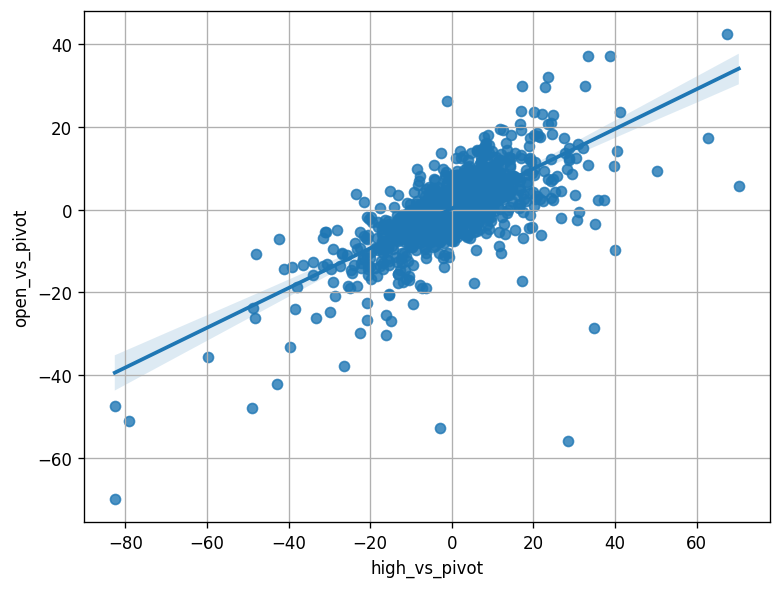

In [8]:
sns.regplot(x=day_data['high_vs_pivot'], y=day_data['open_vs_pivot'])
plt.grid(True)

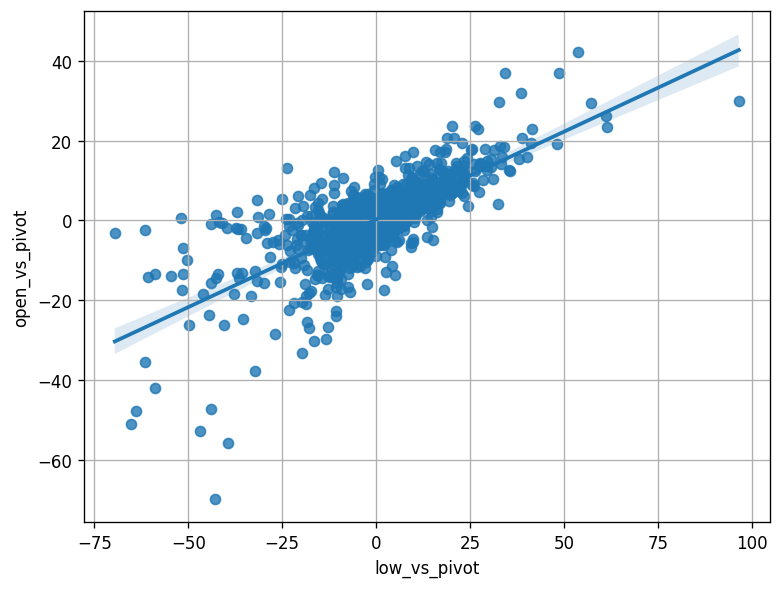

In [9]:
sns.regplot(x=day_data['low_vs_pivot'], y=day_data['open_vs_pivot'])
plt.grid(True)

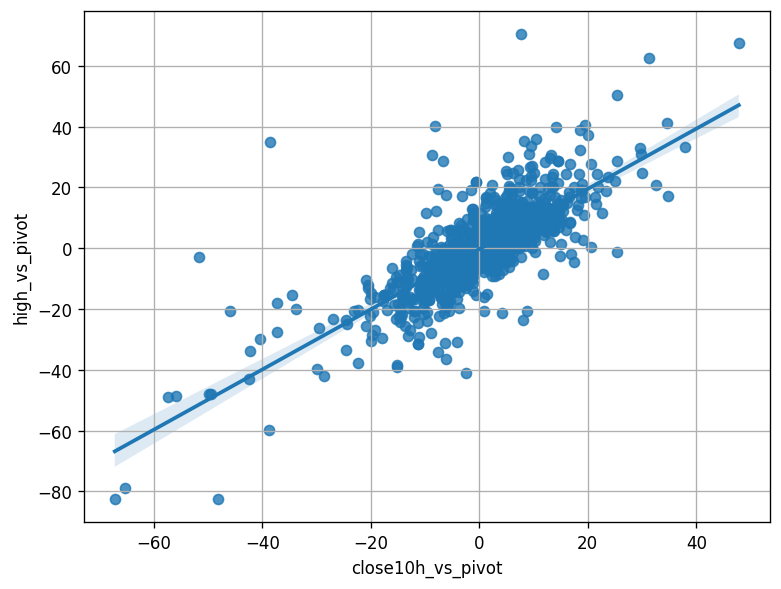

In [10]:
sns.regplot(x=day_data['close10h_vs_pivot'], y=day_data['high_vs_pivot'])
plt.grid(True)

### Heatmap

In [11]:
day_data = day_data[(day_data.close10h_vs_pivot > -20) & (day_data.close10h_vs_pivot < 20) & (day_data.open_vs_pivot > -20) & (day_data.open_vs_pivot < 20)]
day_data['close10h_vs_pivot_group'] = pd.qcut(day_data.close10h_vs_pivot, 20)
day_data['open_vs_pivot_group'] = pd.qcut(day_data.open_vs_pivot, 20)

In [12]:
plt.rcParams['figure.figsize'] = [12, 6]

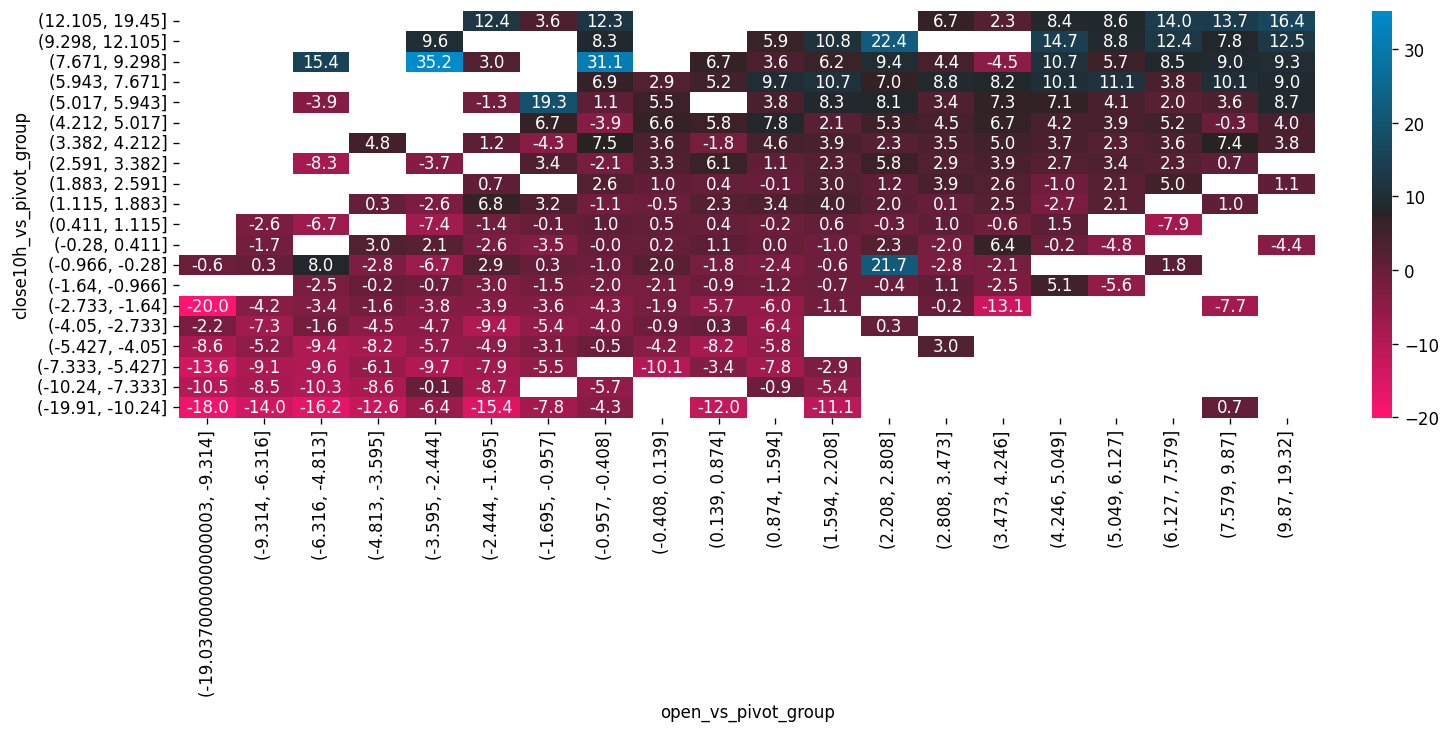

In [13]:
grpd = day_data.groupby(['close10h_vs_pivot_group', 'open_vs_pivot_group'])[['high_vs_pivot']]
irs = grpd.mean().reset_index()
sns.heatmap(
    irs.pivot(index='close10h_vs_pivot_group', columns='open_vs_pivot_group', values='high_vs_pivot').sort_index(ascending=False),
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True, fmt=".1f");

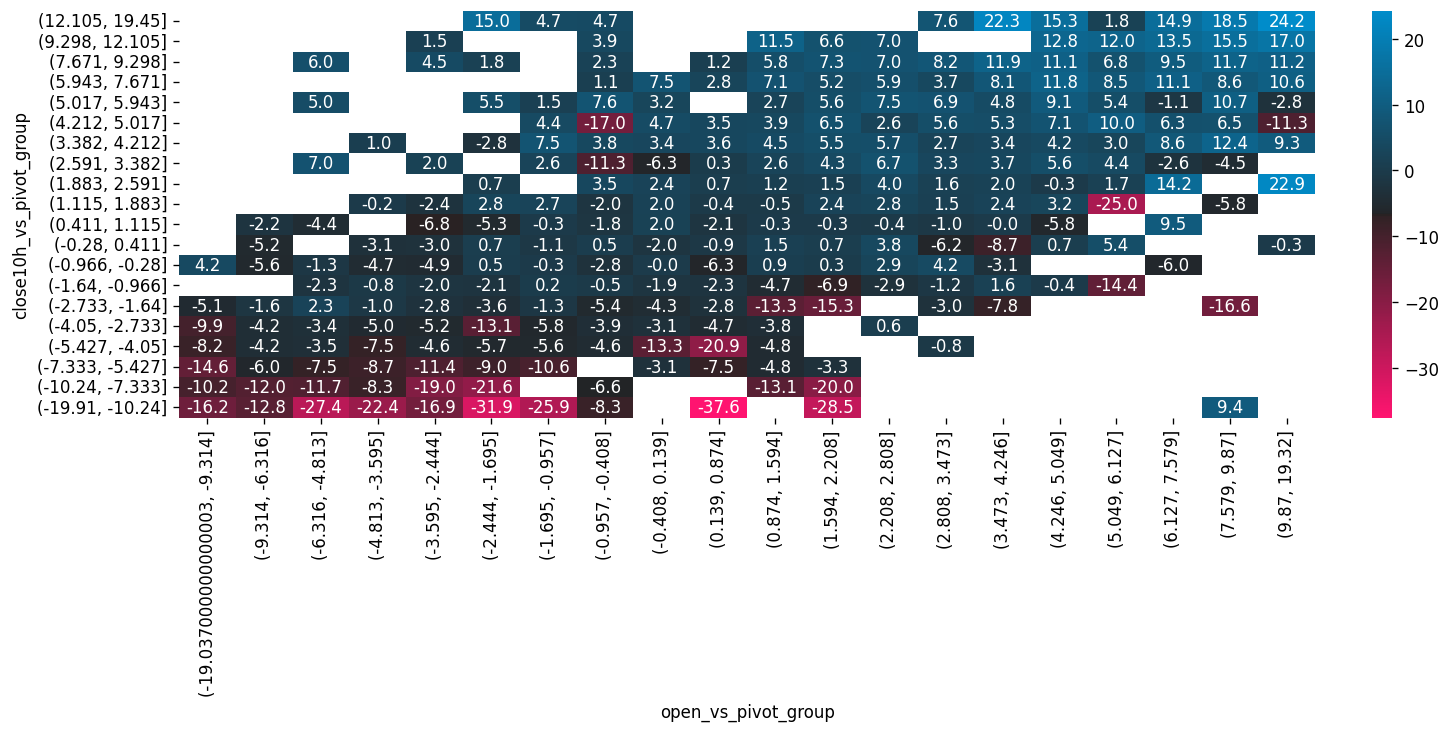

In [14]:
grpd2 = day_data.groupby(['close10h_vs_pivot_group', 'open_vs_pivot_group'])[['low_vs_pivot']]
irs = grpd2.mean().reset_index()
sns.heatmap(
    irs.pivot(index='close10h_vs_pivot_group', columns='open_vs_pivot_group', values='low_vs_pivot').sort_index(ascending=False),
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True, fmt=".1f");